# A two-asset HANK model

THIS NOTEBOOK WAS TAKEN FROM THE SSJ Package!

In this notebook we solve the two-asset HANK model from Auclert, Bardóczy, Rognlie, Straub (2021): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models" ([link to paper](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf)).

New concepts:
- **Solved block**: an extension of simple blocks that enables much more efficient DAG representations of large macro models.
- **Re-using saved Jacobians**: as the cost of these computations becomes non-trivial, avoiding redundancy becomes key.
- **Fine-tuning options**: how to access and modify various options for each (block, method) pair

For more examples and information on the SSJ toolkit, please visit our [GitHub page](https://github.com/shade-econ/sequence-jacobian).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules

## 1 Model description

The household problem is characterized by the Bellman equation
$$
\begin{align} \tag{1}
V_t(e, b_{-}, a_{-}) = \max_{c, b, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}_t V_{t+1}(e', b, a) \right\}
\\
c + a + b &= z_t(e) + (1 + r_t^a)a_{-} + (1 + r_t^b)b_{-} - \Psi(a, a_{-}) 
\\
a &\geq \underline{a}, \quad b \geq \underline{b},
\end{align}
$$

where $z_t(e)$ is labor income and the adjustment cost function is specified as

$$
\Psi(a, a_{-}) =  \frac{\chi_1}{\chi_2}\left|\frac{a - (1 + r_t^a) a_{-}}{(1 + r_{t}^a) a_{-} + \chi_0}\right|^{\chi_2} \left[(1 + r_t^a) a_{-} + \chi_0 \right],
$$

with $\chi_0, \chi_1 > 0$ and $\chi_2 > 1.$ For the full description of the model, including the problems of the other agents, please see appendix B.3 of the paper.

We embed this household block in a New Keynesian model with sticky prices, sticky wages, and capital adjustment costs. Thanks to the **solved blocks** (in green), we can write a DAG for this model in just 3 unknowns $(r, w, Y)$ and 3 targets, asset market clearing, Fisher equation, wage Phillips curve.

## 2 Define solved blocks

Solved blocks are miniature models embedded as blocks inside of our larger model. Like simple blocks, solved blocks correspond to aggregate equilibrium conditions: they map sequences of aggregate inputs directly into sequences of aggregate outputs. The difference is that in the case of simple blocks, this mapping has to be analytical, while solved blocks are designed to accommodate implicit relationships that can only be evaluated numerically. 

Such implicit mappings between variables become more common as macro complexity increases. Solved blocks are a valuable tool to simplify the DAG of large macro models.

### 2.1 Price setting (NKPC-p)
The Phillips curve characterizes $(\pi)$ conditional on $(Y, mc, r):$ 

$$
\log(1+\pi_t) = \kappa_p \left(mc_t - \frac{1}{\mu_p} \right) + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1})
$$

Inflation shows up with two different time displacements, which means that inflation in any given period depends on the entire sequence of $(Y, mc, r)$. Simple blocks are not meant to represent such relationships. Instead, we write a function that returns the residual of the equation, and use the decorator `@solved` to make it into a `SolvedBlock`.

In [2]:
@solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc'], solver="brentq")
def pricing_solved(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / \
           (1 + r(+1)) - (1 + pi).apply(np.log)
    return nkpc

When our routines encounter a solved block in `blocks`, they compute its Jacobian via the the implicit function theorem, as if it was a model on its own. Given the Jacobian, the rest of the code applies without modification. 

### 2.2 Equity price (equity & dividend)
The no arbitrage condition characterizes $(p)$ conditional on $(d, p, r).$

$$
p_t = \frac{d_{t+1} + p_{t+1}}{1 + r_{t+1}}
$$

In [3]:
@solved(unknowns={'p': (5, 15)}, targets=['equity'], solver="brentq")
def arbitrage_solved(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r(+1))
    return equity

### 2.3 Investment with adjustment costs (prod)

Sometimes multiple equilibrium conditions can be combined in a self-contained solved block. Investment subject to capital adjustment costs is such a case. In particular, we can use the following four equations to solve for $(K, Q)$ conditional on $(Y, w, r)$.
 
 - Production:
 
 $$
 Y_t = Z_t K_{t-1}^\alpha N_t^{1-\alpha}
 $$
 
 - Labor demand:
 
 $$
 w_t = (1-\alpha)\frac{Y_t}{N_t} mc_t
 $$
 
 - Investment equation:

$$
Q_t = 1 + \frac{1}{\delta \epsilon_I}\left(\frac{K_t-K_{t-1}}{K_{t-1}}\right)
$$

- Valuation equation

$$
(1+r_{t})Q_{t} = \alpha Z_{t+1} \left(\frac{N_{t+1}}{K_t}\right)^{1-\alpha} mc_{t+1} - \left[\frac{K_{t+1}}{K_t} - (1-\delta) + \frac{1}{2\delta \epsilon_I}\left(\frac{K_{t+1} - K_t}{K_t}\right)^2\right] + \frac{K_{t+1}}{K_t}Q_{t+1}
$$

Solved blocks that contain multiple simple blocks have to be initialized with the `CombinedBlock.solved` method instead of the decorator `@solved`.

In [4]:
@simple
def labor(Y, w, K, Z, alpha):
    N = (Y / Z / K(-1) ** alpha) ** (1 / (1 - alpha))
    mc = w * N / (1 - alpha) / Y
    return N, mc


@simple
def investment(Q, K, r, N, mc, Z, delta, epsI, alpha):
    inv = (K / K(-1) - 1) / (delta * epsI) + 1 - Q
    val = alpha * Z(+1) * (N(+1) / K) ** (1 - alpha) * mc(+1) -\
        (K(+1) / K - (1 - delta) + (K(+1) / K - 1) ** 2 / (2 * delta * epsI)) +\
        K(+1) / K * Q(+1) - (1 + r(+1)) * Q
    return inv, val


production = combine([labor, investment])                              # create combined block
production_solved = production.solved(unknowns={'Q': 1., 'K': 10.},    # turn it into solved block
                                      targets=['inv', 'val'],
                                      solver='broyden_custom')

## 3 Build DAGs

One for transition dynamics (pictured above) and one for calibrating the steady state.

### Step 1: Adapt HA block

We developed an efficient backward iteration function to solve the Bellman equation in (1). Although we view this as a contribution on its own, discussing the algorithm goes beyond the scope of this notebook. If you are interested in how we solve a two-asset model with convex portfolio-adjustment costs in discrete time, please see appendix E of the paper for a detailed description and `sequence_jacobian/hetblocks/hh_twoasset.py` for the implementation.

Here, we take this generic two-asset model off the shelf, and embed it in our New Keynesian model with the help of two hetinputs.

In [5]:
def make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z):
    b_grid = grids.agrid(amax=bmax, n=nB)
    a_grid = grids.agrid(amax=amax, n=nA)
    k_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    return b_grid, a_grid, k_grid, e_grid, Pi


def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid

hh = hetblocks.hh_twoasset.hh
hh_ext = hh.add_hetinputs([income, make_grids])

### Step 2: Complete dynamic DAG with simple blocks

We have set up all the blocks in the `sequence_jacobian/examples/two_asset.py` module. We omit the step-by-step discussion of these blocks since they should be familiar from the other model notebooks.

In [6]:
import sequence_jacobian.examples.two_asset as m

blocks = [hh_ext, production_solved, pricing_solved, arbitrage_solved,
          m.dividend, m.taylor, m.fiscal, m.share_value,
          m.finance, m.wage, m.union, m.mkt_clearing]

hank = create_model(blocks, name='Two-Asset HANK')

print(*hank.blocks, sep='\n')

<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SimpleBlock 'wage'>
<SimpleBlock 'taylor'>
<SimpleBlock 'dividend'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'share_value'>
<SimpleBlock 'finance'>
<SimpleBlock 'fiscal'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>


### Step 3: Complete calibration DAG

Analytical:
- find TFP `Z` to hit target for output `Y`
- find markup `mup` to hit target for total wealth `p + Bg`
- find capital share `alpha` to hit target for capital `K`
- find wage `w` to hit Phillips curve given zero inflation 
- find disutility of labor `vphi` to hit wage Phillips curve given a target for employment

Numerical:
- find discount factor `beta` to satisfy asset market clearing given an interest rate `r`
- find adjustment cost scale `chi1` to hit target for average liquid wealth `Bh`

In [7]:
blocks_ss = [hh_ext, m.partial_ss, m.union_ss,
             m.dividend, m.taylor, m.fiscal, m.share_value, m.finance, m.mkt_clearing]

hank_ss = create_model(blocks_ss, name='Two-Asset HANK SS')

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")


<Model 'Two-Asset HANK SS'>
Inputs: ['beta', 'eis', 'chi0', 'chi1', 'chi2', 'N', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'K', 'r', 'tot_wealth', 'Bg', 'delta', 'muw', 'frisch', 'pi', 'kappap', 'epsI', 'rstar', 'phi', 'G', 'Bh', 'omega']


## 4 Results

We cover how to pass precomputed Jacobians to the main methods. This is useful when methods that need Jacobians are used repeatedly. These are
- Solve methods: `solve_impulse_linear`, `solve_impulse_nonlinear`
- Jacobian methods: `jacobian`, `solve_jacobian`

### 4.1 Calibrate steady state

Use the calibration DAG to internally calibrate the seven parameters (analytical + numerical). Evaluate the dynamic DAG at the resulting steady state `cali`. 

In [8]:
calibration = {'Y': 1., 'N': 1.0, 'K': 10., 'r': 0.0125, 'rstar': 0.0125, 'tot_wealth': 14,
               'delta': 0.02, 'pi': 0., 'kappap': 0.1, 'muw': 1.1, 'Bh': 1.04, 'Bg': 2.8,
               'G': 0.2, 'eis': 0.5, 'frisch': 1., 'chi0': 0.25, 'chi2': 2, 'epsI': 4,
               'omega': 0.005, 'kappaw': 0.1, 'phi': 1.5, 'nZ': 3, 'nB': 50, 'nA': 70, 'nK': 50,
               'bmax': 50, 'amax': 4000, 'kmax': 1, 'rho_z': 0.966, 'sigma_z': 0.92}

unknowns_ss = {'beta': 0.976, 'chi1': 6.5}
targets_ss = {'asset_mkt': 0., 'B': 'Bh'}

cali = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='broyden_custom')

Verify solution, generate `ss` from dynamic DAG.

In [9]:
ss =  hank.steady_state(cali)

print(f"Liquid assets: {ss['B']: 0.2f}")
print(f"Asset market clearing: {ss['asset_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss['goods_mkt']: 0.2e}")

Liquid assets:  1.04
Asset market clearing:  2.82e-13
Goods market clearing (untargeted):  3.29e-08


### 4.2 Linearized impulse responses

As before, we can compute the general equilibrium Jacobians $G$ which is sufficient to map any shock into impulse responses. 

When the cost of computing a block Jacobian is non-trivial, it's a good idea to precompute it. We can supply block Jacobians for specific blocks via the `Js=` keyword argument. The precomputed Jacobians will only be used if they are **complete** (have all required inputs and outputs) and have the right **size** (truncation horizon).

In [10]:
exogenous = ['rstar', 'Z', 'G']
unknowns = ['r', 'w', 'Y']
targets = ['asset_mkt', 'fisher', 'wnkpc']
T = 300

J_ha = hh_ext.jacobian(ss, inputs=['N', 'r', 'ra', 'rb', 'tax', 'w'], T=T)
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T, Js={'hh': J_ha})

The time saving from re-using the Jacobian of the household block is considerable.

In [11]:
%time G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T, Js={'hh': J_ha})

CPU times: user 25.5 s, sys: 403 ms, total: 25.9 s
Wall time: 2.74 s


In [12]:
%time G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

CPU times: user 37.3 s, sys: 1.89 s, total: 39.2 s
Wall time: 5.34 s


Note that some block Jacobians may be precomputed even if others are changing. For example, we can re-use `J_ha` while evalutating the model likelihood for 100,000 draws of price and wage adjustment cost.

When we're not planning to change any part of the model, it's even better to store the `H_U` directly. (To be precise, we store the LU-factorized version of the matrix, which facilitates operations with its inverse.) That way, we save time on computing and packing all the block Jacobians. 

In [13]:
from sequence_jacobian.classes import FactoredJacobianDict

H_U = hank.jacobian(ss, unknowns, targets, T=T, Js={'hh': J_ha})
H_U_factored = FactoredJacobianDict(H_U, T)

In [14]:
%time G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T, Js={'hh': J_ha}, H_U_factored=H_U_factored)

CPU times: user 19.1 s, sys: 493 ms, total: 19.6 s
Wall time: 2.3 s


Let's plot some impulse responses:

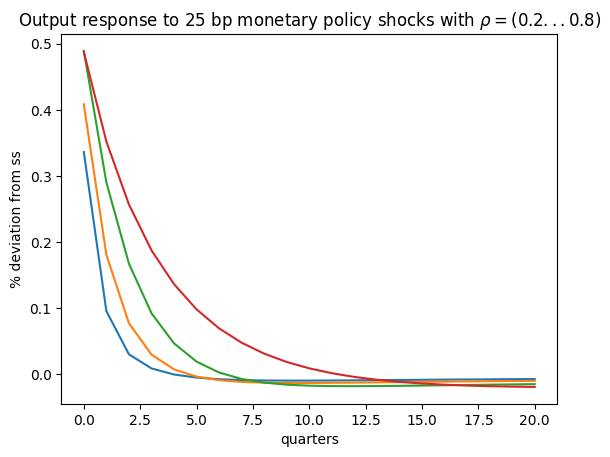

In [15]:
rhos = np.array([0.2, 0.4, 0.6, 0.8])
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dY = 100 * G['Y']['rstar'] @ drstar

plt.plot(dY[:21])
plt.title(r'Output response to 25 bp monetary policy shocks with $\rho=(0.2 ... 0.8)$')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.show()

### 4.3 Nonlinear impulse responses

Let's compute the nonlinear impulse response for the $\rho=0.6$ shock above.
- Don't forget to use the saved Jacobian.
- Note how to look up and change options specific to (block type, method) pairs.

In [16]:
hank['pricing_solved'].solve_impulse_nonlinear_options

{'tol': 1e-08, 'maxit': 30, 'verbose': True}

By default, `SolvedBlock.solve_impulse_linear` prints the error in each iteration (`verbose=True`). Let's turn this off for the internal solved blocks.

In [17]:
td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, {"rstar": drstar[:, 2]},
                                         Js={'hh': J_ha}, H_U_factored=H_U_factored,
                                         options={'pricing_solved': {'verbose': False},
                                                  'arbitrage_solved': {'verbose': False},
                                                  'labor_to_investment_combined_solved': {'verbose': False}})

Solving Two-Asset HANK for ['r', 'w', 'Y'] to hit ['asset_mkt', 'fisher', 'wnkpc']
On iteration 0
   max error for asset_mkt is 3.92E-06
   max error for fisher is 2.50E-03
   max error for wnkpc is 4.72E-08
On iteration 1
   max error for asset_mkt is 2.66E-04
   max error for fisher is 1.55E-06
   max error for wnkpc is 2.15E-05
On iteration 2
   max error for asset_mkt is 7.56E-06
   max error for fisher is 9.69E-08
   max error for wnkpc is 6.57E-07
On iteration 3
   max error for asset_mkt is 4.01E-07
   max error for fisher is 2.24E-09
   max error for wnkpc is 1.64E-08
On iteration 4
   max error for asset_mkt is 2.20E-08
   max error for fisher is 1.06E-10
   max error for wnkpc is 7.46E-10
On iteration 5
   max error for asset_mkt is 1.23E-09
   max error for fisher is 5.44E-12
   max error for wnkpc is 3.72E-11


We see rapid convergence and mild nonlinearities in the solution.

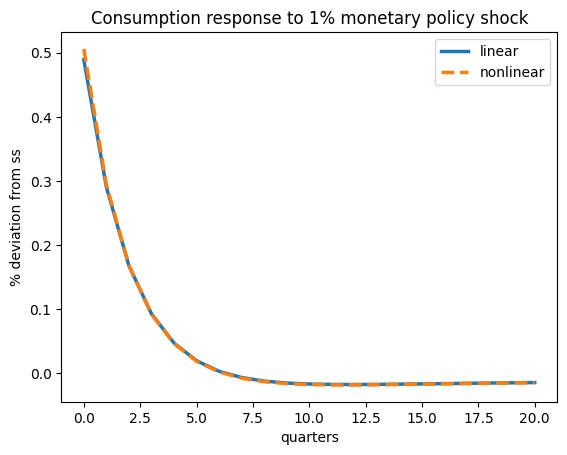

In [18]:
dY_nonlin = 100 * td_nonlin['Y']

plt.plot(dY[:21, 2], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dY_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

Alternatively, we can compute the impulse response to a version of the shock scaled down to 10% of its original size.

In [19]:
td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, {"rstar": 0.1 * drstar[:, 2]},
                                         Js={'hh': J_ha},
                                         options={'pricing_solved': {'verbose': False},
                                                  'arbitrage_solved': {'verbose': False},
                                                  'labor_to_investment_combined_solved': {'verbose': False}})

Solving Two-Asset HANK for ['r', 'w', 'Y'] to hit ['asset_mkt', 'fisher', 'wnkpc']
On iteration 0
   max error for asset_mkt is 3.92E-06
   max error for fisher is 2.50E-04
   max error for wnkpc is 4.72E-08
On iteration 1
   max error for asset_mkt is 3.20E-06
   max error for fisher is 1.63E-08
   max error for wnkpc is 2.10E-06
On iteration 2
   max error for asset_mkt is 7.71E-08
   max error for fisher is 2.53E-10
   max error for wnkpc is 5.83E-09
On iteration 3
   max error for asset_mkt is 8.07E-10
   max error for fisher is 1.50E-12
   max error for wnkpc is 5.69E-11


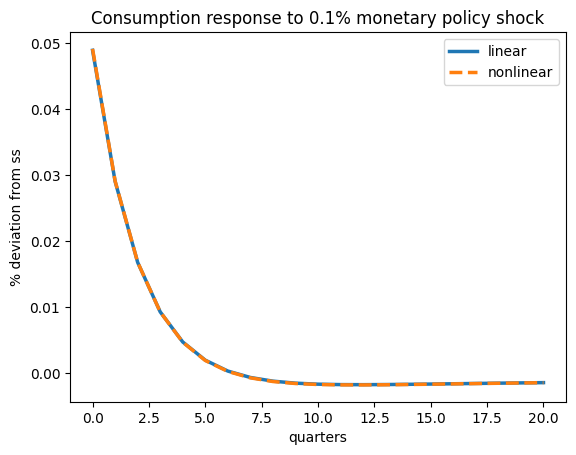

In [20]:
dY_nonlin = 100 * td_nonlin['Y']

plt.plot(0.1*dY[:21, 2], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dY_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 0.1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

When the shock is this small, the linear and nonlinear impulse responses agree exactly. This is a good check, amid a highly complex model, that we didn't make any mistakes.